# Welcome

This Notebook is inspired by and builds on Jeremy Howard's initialization Notebook [here](https://github.com/fastai/course22p2/blob/master/nbs/11_initializing.ipynb). This Notebook assumes a decent understanding of Python and deep learning fundamentals (i.e neural networks, gradient descent).

# Sailing our way to victory

People tend to either chase outcomes or metrics. Both are treacherous paths, because both overlook the importance of *creating the conditions for success to emerge naturally*. 

Pertaining to deep learning, what does this mean? It means that instead of rushing into training a model and blindly tweaking it to satsify our target metrics, we will instead take the time to create the environment where the model trains effectively and learns well. A high accuracy is just a side effect of this. This system allows us to sail our way to victory.

In this Notebook, we will learn how to create an environment for training success, and we will do this looking into our model as its training.

We will be using a module I put together called `gym`. This is a leaner and modified version of `miniai` that you will find [here](https://github.com/fastai/course22p2/tree/df9323235bc395b5c2f58a3d08b83761947b9b93/miniai).

In [5]:
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
from gym import *

In [6]:
import torch
import matplotlib.pyplot as plt
from functools import partial
import torchvision.transforms.functional as TF
from math import sqrt
import fastcore.all as fc
from datasets import load_dataset
from torcheval.metrics import MulticlassAccuracy

Now let's load the data. Nothing crazy here.

In [7]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([6, 3, 1, 6, 5, 3, 2, 5, 4, 1]))

# Initializing the Model for Successful Training

To understand the importance of initializing, we must first see how things go awry without it:

In [4]:
layers = 50

x = torch.randn(100, 50)
w = torch.randn(50, 50)

for i in range(layers): 
    x = x @ w
    
x[0:5,0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

In [ ]:
Try changing `layers` from 10, to 20, and so on. You will see that there is an accumulative effect taking place; the numbers either get very large (or very small, but with large magnitude). This happens due to the repeated matrix multiplications.

Let's see how this trains:

accuracy,loss,epoch,train
0.167,2.269,0,train
0.100,2.330,0,eval


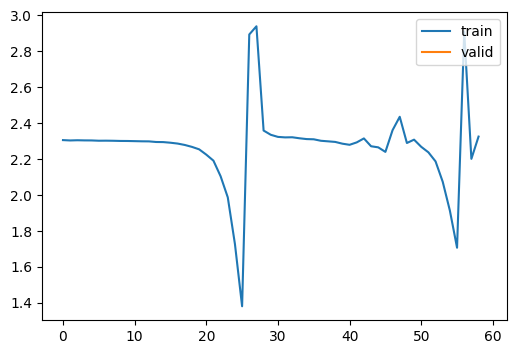

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(torch.nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, torch.nn.functional.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

Horribly unstable and haphazard.

### Why is this haphazardness a problem?

During training, to update weights appropriately, we must calculate gradients of various functions (i.e loss) with respect to weights (and biases). If these values are unstable and oversized, the gradients will be too (as they are literal derivatives).

And this means that the model is **not** learning in a systematic fashion. The weight updates overshadow and destroy any useful information that smaller gradients might carry. Thus, the model can no longer learn the subtle patterns in the data.

It is not uncommon for a network to be 50+ layers deep, to appropriately capture the nuances and complexities of its dataset. Thus, you can see how easily things can fall apart. There is more to say about this problem (exploding gradients), but this is enough for now.

### Why is this happening despite using randn?

The`randn` function that we use to initialize the values of `x` and `w` ensures that the values start with a mean of 0 and a standard deviation of 1; in other words, the values follow a normal (Gaussian) distribution. So why isn't this distribution *maintained* as we propagate through layers?

Even though the initial values are drawn from a standard normal distribution, repeated matrix multiplications, especially with a large number of layers (40 in this case), can lead to very large values. This is because matrix multiplication is not a simple element-wise operation; it involves summing up the products of elements, which can grow exponentially with each layer. 

Each iteration essentially performs a linear transformation on `x`, and repeated applications can lead to a complex transformation, causing the tensor's values to deviate significantly from the initial distribution.

### How do we solve this problem?

We can restrict the values of the activations to be in a certain range. However, simply clipping or restricting the range of activations would likely hamper the model's ability to learn complex patterns.

So, it would seem reasonable to *keep* this (normal) distribution for the activations as they propagate through the layers, would it not? This way, no particular activation(s) will veer off course in great magnitude, as we saw above.

The *values* of the activations may of course differ from one another (as they should, due to varying gradient updates). But by maintaining a normal distribution across layers, we can ensure that the model has the stability needed for training while preserving the *relative* differences between activations.

One way to achieve this is Batch Normalization. Before we do this, let's first define a function to create the convolutional layer (with normalization and activation layers conditionally attached to it).

In [8]:
def conv(ni, nf, ks=3, stride=2, act=torch.nn.ReLU, norm=None, bias=None):
    is_batch_norm = isinstance(norm, (
        torch.nn.BatchNorm1d,
        torch.nn.BatchNorm2d,
        torch.nn.BatchNorm3d
    ))
    # the bias is redundant when doing batch normalization as this is captured by the 'shift'
    if bias is None: bias = not is_batch_norm
    layers = [torch.nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return torch.nn.Sequential(*layers)

### Understanding the code

#### Function Signature:
- `def conv(ni, nf, ks=3, stride=2, act=torch.nn.ReLU, norm=None, bias=None)`: Its parameters are:
    - `ni`: Number of input channels for the convolutional layer.
    - `nf`: Number of output channels (filters) for the convolutional layer.
    - `ks`: Kernel size for the convolutional filter. It defaults to 3.
    - `stride`: Stride for the convolutional operation. It defaults to 2.
    - `act`: Activation function to use after the convolution. The default is a vanilla ReLU.
    - `norm`: Normalization layer to apply after the convolution. It's optional.
    - `bias`: Whether or not to use a bias term in the convolutional layer.

#### Creating a Convolutional Layer:
- `layers = [torch.nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]`:
    - This line creates a 2D convolutional layer with the specified number of input/output channels, stride, kernel size, padding (calculated as ks//2 for ensuring the output size remains consistent), and bias. 
    - This layer is added to the layers list.

Then, conditionally add Normalization and Activation.

#### Output
- Returns a `torch.nn.Sequential` module containing the constructed layers. This makes it easy to integrate this block into larger neural network architectures.

Now let's see if this stabilizes our training.

accuracy,loss,epoch,train
0.828,0.463,0,train
0.861,0.375,0,eval
0.882,0.317,1,train
0.857,0.383,1,eval
0.897,0.280,2,train
0.875,0.338,2,eval


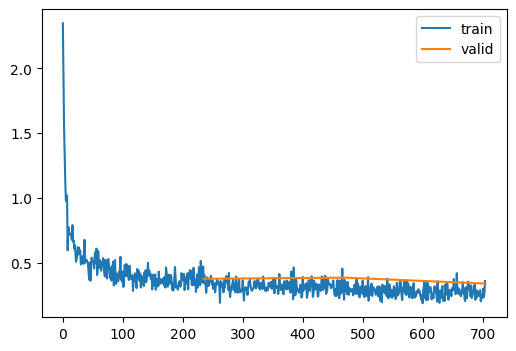

In [9]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)
model = get_model(act=torch.nn.ReLU, norm=torch.nn.BatchNorm2d)
set_seed(15)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(torch.nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(model, dls, torch.nn.functional.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

Much better. Now let's see how the mean and variances are throughout training:

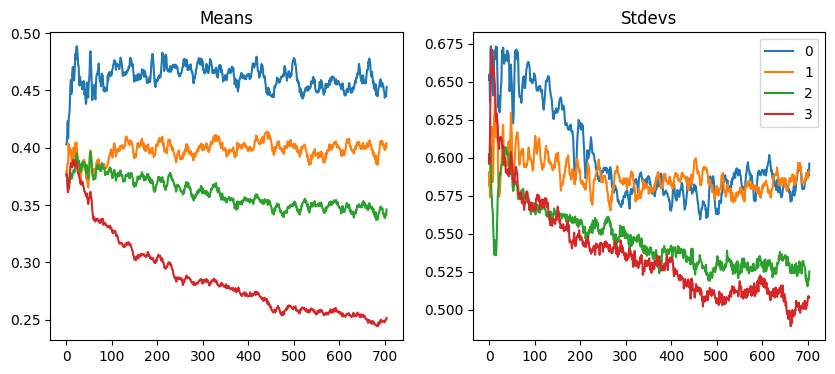

In [12]:
astats.plot_stats()

So the accuracy is decent, but the means are not zero (we'll see more about why, later in this Notebook). 

But to understand what's really going on in Batch Normalization, let's define our own function that does something quite similar.

In [ ]:
class BatchNorm(torch.nn.Module):
    def __init__(self, nf, momentum=0.1, eps=1e-5):
        super().__init__()
        self.momentum,self.eps = momentum,eps
        self.scale = torch.nn.Parameter(torch.ones (nf,1,1))
        self.shift  = torch.nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.momentum)
        self.vars.lerp_ (v, self.momentum)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.scale + self.shift

Let's see below what's going on here:

### Understanding the code

#### Class
- `class BatchNorm(torch.nn.Module)`: This line defines a new class that inherits from PyTorch's `torch.nn.Module`. This is a custom implementation of a batch normalization layer.

#### Constructor
- `def __init__(self, nf, momentum=0.1, eps=1e-5)`: The constructor initializes the layer with the following parameters:
    - **nf**: The number of features (channels) in the input.
    * **momentum**: Momentum for the running mean and variance. It's set to 0.1 by default.
    * **eps**: A small constant added for numerical stability, set to 1e-5 by default.
- **self.scale** and **self.shift**: These are learnable scale (gamma) and shift (beta) parameters, respectively, initialized to ones (for scaling) and zeros (for shifting). They are implemented as `torch.nn.Parameter` to indicate that they should be learned during training.
- **self.register_buffer**: This method is used to register buffers, `vars` and `means`, which are *not* learnable parameters but are part of the model's state. `vars` is initialized to ones and `means` to zeros. These buffers store the running variance and mean, respectively.

#### Method update_stats
- `def update_stats(self, x)`: This method updates the running means and variances based on the input `x`. 
    - It computes the mean (`m`) and variance (`v`) of `x` across specified dimensions (batch, height, and width, but not channels).
- `self.means.lerp_` and `self.vars.lerp_`:
    - These lines update the running means and variances using linear interpolation with `momentum`.

#### Method forward
- `def forward(self, x)`: This method defines the forward pass of the layer. 
    - If the layer is in training mode (`self.training` is `True`), it updates the running statistics `(m, v)` and uses these for normalization.
    - If not, it uses the stored running means and variances.
    - The normalization is done by subtracting the mean and dividing by the square root of variance plus `eps`.
    - Finally, it applies the learnable scale (`self.scale`) and shift (`self.shift`) parameters.
    
### Understanding lerp_:
- `lerp_` stands for linear interpolation. In PyTorch, this function is used to update a value by moving it closer to another value. 
- The formula for `lerp_` is typically: `new_value = old_value + momentum * (target_value - old_value)`.
- This is an in-place operation, indicated by the underscore at the end of `lerp_`, meaning it modifies the data of `self.means` and `self.vars` directly.

#### Application in Batch Normalization:
- Running Mean (`self.means`): 
    - This buffer stores the running average of the means of the features (over the batches seen during training). The `lerp_` function is used to update this running mean, blending it with the mean of the current batch (`m`). The degree of blending is controlled by the momentum parameter (`self.momentum`).
- Running Variance (`self.vars`): Similarly, this buffer keeps track of the running average of variances of the features. It is updated using the variance of the current batch (`v`), again moderated by the momentum term.

#### The Point:
- To accumulate stable statistics over the entire training dataset, which can generalize well to unseen data.

### Why does batch normalization need to know the number of filters (`nf`)?
- Per-Channel Parameters: Since `BatchNorm` operates independently on each feature channel, it needs to know the number of channels (`nf`) to create the appropriate number of scaling and shifting parameters.
- Running Statistics: `BatchNorm` tracks running averages of means and variances for each feature map, which also requires knowing the number of feature maps.

We can also try a similar (and simpler) approach, called layer normalization.

In [ ]:
class LayerNorm(torch.nn.Module):
    def __init__(self, filler, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.scale = torch.nn.Parameter(torch.tensor(1.))
        self.shift  = torch.nn.Parameter(torch.tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.scale + self.shifta

### Understanding the code

#### Class Definition 

- `LayerNorm(nn.Module)`:
    - This is a custom class LayerNorm that inherits from `nn.Module`, the base class for all neural network modules in PyTorch.
    
#### Constructor
- `def __init__(self, filler, eps=1e-5)`: The constructor takes two arguments: `filler` and `eps`.
    - `filler` is necessary because of how the `conv` function above invokes the `norm` argument, passing in the number of filters (which is needed for batch normalization as mentioned above).
    - The `eps` argument is used for numerical stability and is set to a default value of 1e-5.
- `self.scale` and `self.shift` are learnable parameters initialized to 1 and 0, respectively. These parameters will be adjusted during the training process.

#### Forward Method (`forward`):
- This method defines how the module processes input data (x).
- `x.mean((1,2,3), keepdim=True)`:
    - Computes the mean of `x` across dimensions 1, 2, and 3, while keeping the dimensions (not flattening them).
- `x.var ((1,2,3), keepdim=True)`
    - Computes the variance of `x` across the same dimensions.
- `x = (x-m) / ((v+self.eps).sqrt())`
    - Normalizes x by subtracting the mean `m` and dividing by the square root of the variance `v` plus `eps` (for numerical stability).
- `return x * self.scale + self.shift`:
    - Scales the normalized data by `self.scale` and shifts it by `self.shift`. These are learnable parameters that allow the layer to adjust the normalization process during training.

## Batch vs Layer Normalization
Some notable differences between the two types of normalization are as follows:

1. Normalization Scope
- `BatchNorm`: 
    - Normalizes the input across the batch dimension. 
    - Computes the mean and variance for each feature channel over the batch and spatial dimensions (height and width). 
    - This is evident in the line `m = x.mean((0,2,3), keepdim=True)` in `BatchNorm`, where it calculates the mean over the batch, height, and width dimensions, but not the channel dimension.
- `LayerNorm`: 
    - Normalizes the input per data point (per layer).
    - Computes the mean and variance for each individual data point over all features. 
    - This is evident in the line `m = x.mean((1,2,3), keepdim=True)` in `LayerNorm` where it calculates the mean over the channel, height, and width dimensions, but separately for each item in the batch.
2. Running Statistics
- `BatchNorm`: 
    - Maintains running averages of the mean and variance during training (using `self.means` and `self.vars`), which are used during evaluation.
- `LayerNorm`: 
    - Does not maintain running averages of mean and variance. 
    - Each input is normalized based on its own mean and variance.
3. Learnable Parameters
- Both layers have learnable scale (`self.scale`) and shift (`self.shift`) parameters, but they are applied differently due to the different scopes of normalization.

4. Applicability and Effects:
- `BatchNorm`: 
   - Effective in regularizing the model and accelerating training. 
   - Sensitive to the batch size since it normalizes over the batch dimension.
-`LayerNorm`: 
   - Particularly useful in models where the batch size is small or varies, as it computes statistics for each data point independently of the batch. 
   - Often used transformer models.
   
5. Momentum and Update Strategy
- `BatchNorm`: 
    - Uses a momentum parameter to update running statistics and applies these statistics during the model's evaluation phase.
- `LayerNorm`:
    - There's no concept of momentum or running statistics.
    - normalization is based entirely on the statistics of the current input.
    
### Summary
Both aim to stabilize training by normalizing the inputs to the layers. But they differ in how they compute and apply these normalizations.

Adjust the learning rate. Play with not having to initlaize. play with a custom relu.

Below is a nice illustration from [here](https://ai.stackexchange.com/questions/27309/what-are-the-consequences-of-layer-norm-vs-batch-norm).

![Differences between normalizations](../images/norms.png)

## Experimentation

Now is where the real experimentation begins. See if you can make the accuracy better but tweaking things, changing things, etc. Here are some ideas:

#### Activation Function
You may wish to try a different activation function instead of a vanilla ReLU. Remember that an activation function like ReLU introduces a discontinuity in the otherwise linear layers of a neural network, allowing the function of the entire network to be non-linear. This is important because life, outside of man-made domains like games, does not follow straight lines of logic. I've written a bit more about this [here](https://x.com/PrefectureCo/status/1739285307533713655).

The vanilla ReLU simply cannot produce activations with a mean of zero and variance of 1 unless all activation values are zero; this is evident by its shape.

![Vanilla ReLU](../images/relu.png)

So, let's shift the ReLU down so that when its applied to produce activations, the activations can be normally distributed. 

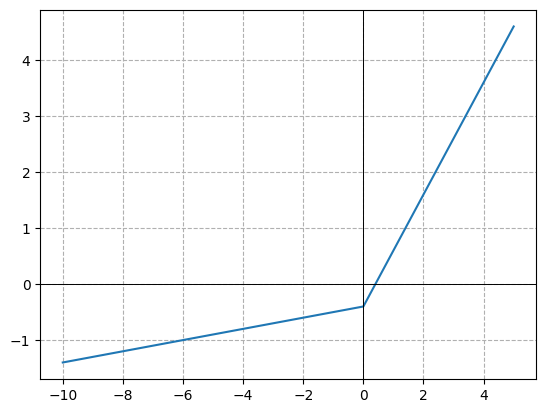

In [14]:
class CustomReLU(torch.nn.Module):
    def __init__(self, leak=None, sub=None):
        super().__init__()
        self.leak, self.sub = leak, sub

    def forward(self, x):
        if self.leak is None:
            x = torch.nn.functional.relu(x) 
        else:
            x = torch.nn.functional.leaky_relu(x, self.leak) 
        if self.sub is not None: x -= self.sub
        return x

x = torch.linspace(-10, 5, 100)
plt.plot(x, CustomReLU(leak=0.1, sub=0.4)(x))
plt.grid(True, which='both', ls='--')
plt.axhline(y=0, color='k', linewidth=0.7)
plt.axvline(x=0, color='k', linewidth=0.7)

Above, we also allow the ReLU to be [leaky](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html). What's the purpose of this? In a standard ReLU, if the input to a neuron is negative, the output is zero. During the backpropagation process, this leads to zero gradient for these neurons, and they stop getting updates (i.e stop learning). If this happens at a large enough scale, the model itself can't learn effectivly. So, the leak aims to mitigate this by allowing a small, non-zero gradient when the unit is not active. All credit for this idea goes to Jeremy Howard, and you can learn about it [here](https://github.com/fastai/course22p2/blob/master/nbs/11_initializing.ipynb) and [here](https://www.youtube.com/watch?v=vGsc_NbU7xc).

Let's use this ReLU:

accuracy,loss,epoch,train
0.835,0.454,0,train
0.817,0.466,0,eval
0.879,0.323,1,train
0.870,0.344,1,eval
0.893,0.287,2,train
0.882,0.325,2,eval


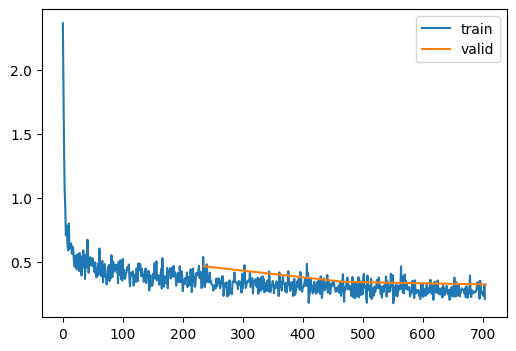

In [32]:
model = get_model(act=partial(CustomReLU, leak=0.1, sub=0.4), norm=torch.nn.BatchNorm2d)
set_seed(15)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(CustomReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(model, dls, torch.nn.functional.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

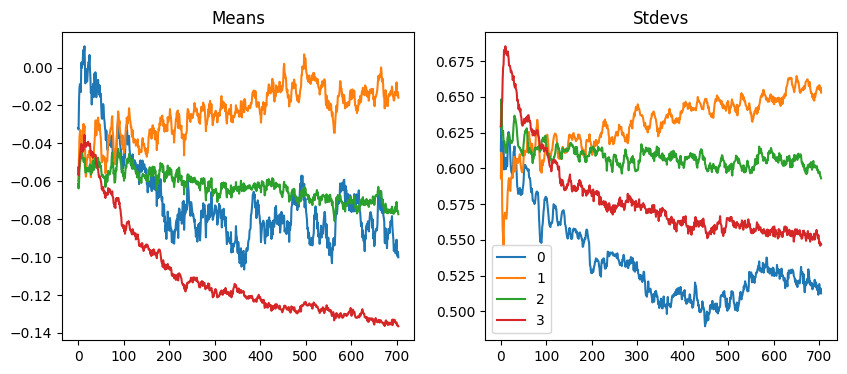

In [33]:
astats.plot_stats()

In [ ]:
Means are a lot closer to zero now.

Other things you can do are to increase/decrease the learning rate, or try normalizing the weights as an initialization step before each layer.

An example of the latter would be to do a Kaiming/He initialization, as described [here](https://arxiv.org/abs/1502.01852). To scale the weights, we use the following scale: $\sqrt{2 / n_{in}}$, where $n_{in}$ is the number of inputs of our model.

Luckily this is already implemented in `torch.nn.init`; So, let's create a handy function to initialize the weights:

In [26]:
def init_weights(layer, leaky=0.):
    if isinstance(layer, (
        torch.nn.Conv1d,
        torch.nn.Conv2d,
        torch.nn.Conv3d
    )): torch.nn.init.kaiming_normal_(layer.weight, a=leaky)

We can apply this to every layer in the model like this: `get_model(act=torch.nn.ReLU, norm=torch.nn.BatchNorm2d).apply(init_weights)`. Let's apply it to our Custom ReLU, with a leaky factor.

accuracy,loss,epoch,train
0.832,0.463,0,train
0.835,0.429,0,eval
0.878,0.327,1,train
0.871,0.347,1,eval
0.893,0.289,2,train
0.880,0.327,2,eval


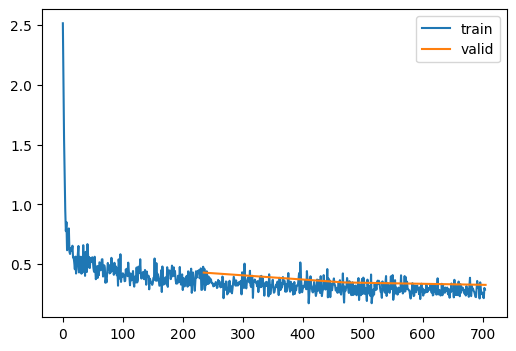

In [34]:
model = get_model(act=partial(CustomReLU, leak=0.1, sub=0.4), norm=torch.nn.BatchNorm2d).apply(partial(init_weights, leaky=0.1))
set_seed(15)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(CustomReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(model, dls, torch.nn.functional.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

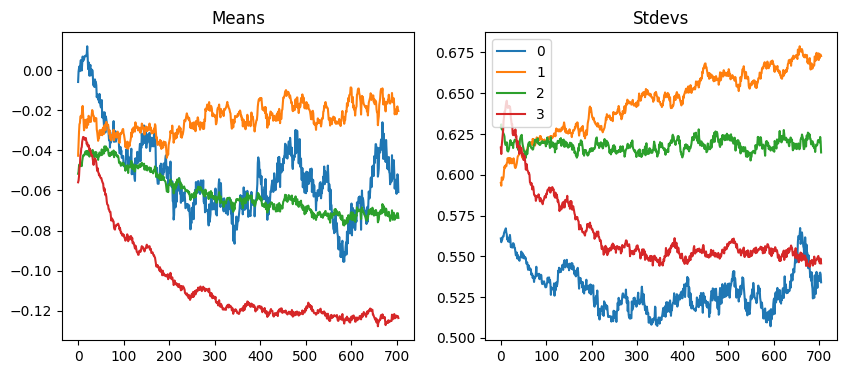

In [30]:
astats.plot_stats()

# Conclusion
You may now see the importance of creating the environment for effective training. Thanks for following along.